# Importing the necessary libraries

In [ ]:
# Standard Libraries
import os
import shutil
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from glob import glob

# Third-Party Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, float32
from PIL import Image
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# GPU information


In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print(cuda.is_available())  # Should print True

True


In [ ]:
cuda.detect()  # Detects GPU and initializes CUDA context

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-647d90e4-6dfb-0faf-b952-1671a2886e0f
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

# Gamma correlation

In [ ]:
def gamma_correction(image_path, gamma=1.0):
    """
    Apply gamma correction to a single image.

    Args:
        image_path (str): Path to the input image.
        gamma (float): Gamma correction factor.

    Returns:
        np.ndarray: Gamma-corrected image.
    """
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=np.float32)

    corrected_img = ((img_array / 255.0) ** gamma) * 255.0
    return corrected_img.astype(np.uint8)

def process_and_save_image(image_path, output_dir, gamma):
    """
    Process an image and save the gamma-corrected result.

    Args:
        image_path (str): Path to the input image.
        output_dir (str): Directory to save the processed image.
        gamma (float): Gamma correction factor.
    """
    corrected_img = gamma_correction(image_path, gamma)
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    Image.fromarray(corrected_img).save(output_path)

def parallel_process_images(image_dir, output_dir, gamma, max_workers=8):
    """
    Apply gamma correction to a dataset of images in parallel.

    Args:
        image_dir (str): Directory containing input images.
        output_dir (str): Directory to save processed images.
        gamma (float): Gamma correction factor.
        max_workers (int): Number of parallel workers.
    """
    os.makedirs(output_dir, exist_ok=True)
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png'))]

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for image_path in image_paths:
            executor.submit(process_and_save_image, image_path, output_dir, gamma)




In [ ]:
input_folder = 'COVID-19_Radiography_Dataset/COVID/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/gamma_correl/COVID'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)
gamma = 0.9  # Brighten images

parallel_process_images(input_folder, output_folder, gamma)

In [ ]:
# Example usage
#input_folder = 'Covid19-dataset/train/Covid/'
input_folder = 'COVID-19_Radiography_Dataset/Normal/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/gamma_correl/Normal'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)
gamma = 0.9  # Brighten images

parallel_process_images(input_folder, output_folder, gamma)

# CLAHE

In [ ]:
@cuda.jit
def clahe_kernel(img, result, tile_size, clip_limit):
    x, y = cuda.grid(2)
    height, width = img.shape

    # Ensure that thread coordinates are within image bounds
    if x >= height or y >= width:
        return

    # Calculate the tile position
    tile_x = x // tile_size[0]
    tile_y = y // tile_size[1]

    # Calculate histogram and clip based on the limit
    # This simplified kernel can be modified to create cumulative histograms for actual CLAHE.

    # Clip values based on clip limit
    local_val = img[x, y] * (clip_limit / 255.0)  # Example processing

    # Store in result
    result[x, y] = min(255, max(0, local_val))

# Function to apply CLAHE to an image
def clahe_gpu(img, tile_grid_size=(8, 8), clip_limit=2.0):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    result = np.zeros_like(img_gray)

    # Move data to device
    d_img = cuda.to_device(img_gray)
    d_result = cuda.to_device(result)

    # Set up CUDA grid and block dimensions
    threads_per_block = (16, 16)
    blocks_per_grid_x = int(np.ceil(img_gray.shape[0] / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(img_gray.shape[1] / threads_per_block[1]))

    # Launch kernel
    clahe_kernel[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_img, d_result, tile_grid_size, clip_limit)

    # Copy result back to host
    result = d_result.copy_to_host()

    return result


In [ ]:
# Function to read, process, and save an image
def process_image(image_path, output_folder, tile_grid_size, clip_limit):
    img = cv2.imread(image_path)

    result_img = clahe_gpu(img, tile_grid_size, clip_limit)

    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, result_img)
    #print(f'Processed and saved {output_path}')

# Main function to handle parallel processing
def process_images_in_folder(input_folder, output_folder, tile_grid_size=(8, 8), clip_limit=40.0):
    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Get all image file paths
    image_files = glob(os.path.join(input_folder, '*.png'))

    # Use ThreadPoolExecutor for I/O-bound tasks like reading and saving
    with ThreadPoolExecutor(max_workers=8) as executor:
        # Process images in parallel
        futures = [executor.submit(process_image, img_path, output_folder, tile_grid_size, clip_limit)
                   for img_path in image_files]

        # Wait for all futures to complete
        for future in futures:
            future.result()  # This will raise exceptions if any occur in threads



In [ ]:
input_folder = 'COVID-19_Radiography_Dataset/COVID/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/clahe/COVID'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

process_images_in_folder(input_folder, output_folder, tile_grid_size=(8, 8), clip_limit=300.0)

In [ ]:
input_folder = 'COVID-19_Radiography_Dataset/Normal/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/clahe/Normal'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

process_images_in_folder(input_folder, output_folder, tile_grid_size=(8, 8), clip_limit=300.0)

# Kalman Filter


In [ ]:
@cuda.jit
def kalman_filter_gpu(img, filtered_img):
    row, col = cuda.grid(2)

    if row < img.shape[0] and col < img.shape[1]:
        # Handle boundary conditions for neighbors
        up = img[max(0, row - 1), col]  # Pixel above
        left = img[row, max(0, col - 1)]  # Pixel to the left

        # Apply the Kalman-like filter
        filtered_value = img[row, col] * 0.9 + (up * 0.05 + left * 0.05)

        # Ensure the value stays within [0, 1]
        filtered_img[row, col] = min(max(filtered_value, 0.0), 1.0)


def apply_kalman_filter(img):
    # Ensure the input is a 2D grayscale image of type float32 and normalized
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if RGB
    img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Create output array
    filtered_img = np.zeros_like(img, dtype=np.float32)

    # Transfer input and output arrays to GPU
    d_img = cuda.to_device(img)
    d_filtered_img = cuda.to_device(filtered_img)

    # Define block and grid sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]

    # Launch the kernel
    kalman_filter_gpu[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_img, d_filtered_img)

    # Copy the filtered image back to the host
    d_filtered_img.copy_to_host(filtered_img)

    # Rescale the output to [0, 255] and convert to uint8
    return (filtered_img * 255.0).astype(np.uint8)


In [ ]:
# Function to read, process, and save an image
def process_image(image_path, output_folder):
    img = cv2.imread(image_path)

    result_img = apply_kalman_filter(img)

    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, result_img)
    #print(f'Processed and saved {output_path}')

# Main function to handle parallel processing
def process_images_in_folder(input_folder, output_folder):
    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Get all image file paths
    image_files = glob(os.path.join(input_folder, '*.png'))

    # Use ThreadPoolExecutor for I/O-bound tasks like reading and saving
    with ThreadPoolExecutor(max_workers=8) as executor:
        # Process images in parallel
        futures = [executor.submit(process_image, img_path, output_folder)
                   for img_path in image_files]

        # Wait for all futures to complete
        for future in futures:
            future.result()  # This will raise exceptions if any occur in threads



In [ ]:
# Kalman preprocessing
input_folder = 'COVID-19_Radiography_Dataset/COVID/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/kalman/COVID'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

process_images_in_folder(input_folder, output_folder)

In [ ]:
# Kalman preprocessing
input_folder = 'COVID-19_Radiography_Dataset/Normal/segmentation/'
output_folder = 'COVID-19_Radiography_Dataset/kalman/Normal'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

process_images_in_folder(input_folder, output_folder)

### Dataset splitting

Split datasets of each preprocessing method into train, validation and test folders.

In [ ]:
# Paths
original_dataset_dir = 'gamma_correl'
output_dir = 'gamma_correl/split_dataset'

# Create output directories
for split in ['train', 'validation', 'test']:
    for cls in ['COVID', 'Normal']:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split function
def split_data(original_dir, output_dir, val_ratio=0.2, test_ratio=0.1):
    for cls in ['COVID', 'Normal']:
        class_dir = os.path.join(original_dir, cls)
        images = os.listdir(class_dir)

        # Split into train, validation, and test
        train_images, temp_images = train_test_split(images, test_size=val_ratio + test_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

        # Copy images to new directories
        for split, image_list in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
            for image in image_list:
                src = os.path.join(class_dir, image)
                dst = os.path.join(output_dir, split, cls, image)
                shutil.copy(src, dst)

# Apply split
split_data(original_dataset_dir, output_dir)


In [ ]:
# Directories for input images, masks, and output results
images_dir = 'images'
masks_dir = 'masks'
output_dir = 'segmentation'
mask_shape = (299, 299)


# Get the list of image and mask filenames
image_files = sorted([f for f in os.listdir(images_dir)])
mask_files = sorted([f for f in os.listdir(masks_dir)])

# Process each image and its corresponding mask
for i in range(len(image_files)):
    image_path = 'images/'+image_files[i]
    mask_path = 'masks/'+mask_files[i]

    # Load and convert the image to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Load and convert the mask to grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to the fixed shape
    mask = cv2.resize(mask, (299, 299))

    # Ensure the mask is binary (values 0 or 1)
    binary_mask = (mask > 0).astype(np.uint8)

    # Calculate the Area of Interest (AOI)
    aoi = image * binary_mask

    # Save the AOI result
    output_path = os.path.join(output_dir, image_files[i])
    cv2.imwrite(output_path, aoi)



In [ ]:
# Define the path to the folder containing images
source_dir = 'gamma_correl/split_dataset/validation/COVID/'
dummy_dir = os.path.join(source_dir, 'all_images')  # Path to the new dummy subdirectory

# Create the dummy directory if it doesn't exist
if not os.path.exists(dummy_dir):
    os.makedirs(dummy_dir)

# Move all image files into the dummy directory
for filename in os.listdir(source_dir):
    # Ensure it's an image file (you can extend the filter as needed)
    if filename.endswith(('.png')):
        # Define full file paths
        src_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dummy_dir, filename)

        # Move the file
        shutil.move(src_path, dest_path)

print(f"All images moved to: {dummy_dir}")


All images moved to: gamma_correl/split_dataset/validation/COVID/all_images


### Data augmentation

Apply data augmentation to train and validation dataset of each preprocessing method.

In [ ]:
# Path to the folder
folder_path = "gamma_correl/split_dataset/validation/COVID/"

# Initialize the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(rotation_range=20)

# Create a generator for loading images
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(299, 299),  # Resize images to 150x150
    batch_size=32,
    class_mode=None,
    shuffle=True,
    save_prefix='aug',
    save_to_dir="gamma_correl/split_dataset/validation/COVID/all_images",  # Save augmented images
    save_format="png"
)


Found 723 images belonging to 1 classes.


In [ ]:
# Define the folder path
folder_path = "gamma_correl/split_dataset/validation/COVID/all_images"

# List all files in the folder and filter only image files (e.g., .jpg, .png)
image_files = [f for f in os.listdir(folder_path) if f.endswith((".png"))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the folder: {num_images}")


Number of images in the folder: 2022


In [ ]:
# Delete images
'''
folder_path = 'clahe/split_dataset/validation/COVID/all_images'
prefix = 'aug'

for filename in os.listdir(folder_path):
    if filename.startswith(prefix):
        file_path = os.path.join(folder_path, filename)
        os.remove(file_path)
'''

In [ ]:
iterations_train = 4460//32
iterations_validation = 1300//32

In [ ]:
# Apply augmentation generator
for i, batch in enumerate(generator):
    if i >= (iterations_validation):
        break

Load final train, validation and test data for the models

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data_clahe = train_datagen.flow_from_directory(
    'clahe/split_dataset/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

validation_data_clahe = val_test_datagen.flow_from_directory(
    'clahe/split_dataset/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_data_clahe = val_test_datagen.flow_from_directory(
    'clahe/split_dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


2025-01-17 11:37:17.380601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737113837.432286    1835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737113837.446133    1835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 11:37:17.568252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14119 images belonging to 2 classes.
Found 4060 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


In [ ]:
# Load data
train_data_kalman = train_datagen.flow_from_directory(
    'kalman/split_dataset/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

validation_data_kalman = val_test_datagen.flow_from_directory(
    'kalman/split_dataset/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_data_kalman = val_test_datagen.flow_from_directory(
    'kalman/split_dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 14116 images belonging to 2 classes.
Found 4060 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


In [ ]:
# Load data
train_data_gamma = train_datagen.flow_from_directory(
    'gamma_correl/split_dataset/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

validation_data_gamma = val_test_datagen.flow_from_directory(
    'gamma_correl/split_dataset/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_data_gamma = val_test_datagen.flow_from_directory(
    'gamma_correl/split_dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 14116 images belonging to 2 classes.
Found 4060 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


# VGG16

## Model

In [ ]:
# Adjust gpu memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
# Define VGG16 model
vgg_base = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
)

# Unfreezing last 4 layers for training
vgg_base.trainable = True

for layer in vgg_base.layers[:-4]:
    layer.trainable = False

I0000 00:00:1737113861.274538    1835 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [ ]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Model definition
def create_model():
    x = Flatten()(vgg_base.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=vgg_base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define callbacks functions
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)]

# Define training function
def train_model(model, train_data, epochs, validation_data):
    model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks = callbacks)

# Create model
model_clahe = create_model()
model_kalman = create_model()
model_gamma = create_model()


In [ ]:
# Train 3 models in parallel
with ThreadPoolExecutor(max_workers=3) as executor:
    history_clahe = executor.submit(train_model, model_clahe, train_data_clahe, 40, validation_data_clahe)
    history_kalman = executor.submit(train_model, model_kalman, train_data_kalman, 40, validation_data_kalman)
    history_gamma = executor.submit(train_model, model_gamma, train_data_gamma, 40, validation_data_gamma)

Epoch 1/40
Epoch 1/40
Epoch 1/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - accuracy: 0.8083 - loss: 0.6857 - val_accuracy: 0.9438 - val_loss: 0.1383
Epoch 2/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.8296 - loss: 0.4824 - val_accuracy: 0.9362 - val_loss: 0.1539
Epoch 2/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 86s 184ms/step - accuracy: 0.8352 - loss: 0.4558 - val_accuracy: 0.9453 - val_loss: 0.1386
Epoch 2/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 71s 160ms/step - accuracy: 0.9325 - loss: 0.1635 - val_accuracy: 0.9493 - val_loss: 0.1471
Epoch 3/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 77s 175ms/step - accuracy: 0.9342 - loss: 0.1561 - val_accuracy: 0.9475 - val_loss: 0.1375
Epoch 3/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 77s 174ms/step - accuracy: 0.9425 - loss: 0.1417 - val_accuracy: 0.9490 - val_loss: 0.1338
Epoch 3/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 72s 162ms/step - accuracy: 0.9524 - loss: 0.1223 - val_accuracy: 0.9579 - val_loss: 0.1112
Epoch 4/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 74s 168ms/step - accu

In [ ]:
trained_model_clahe = history_clahe.result()
trained_model_kalman = history_kalman.result()
trained_model_gamma = history_gamma.result()

In [ ]:
# Save models
model_clahe.save("vgg16_clahe.keras")
model_kalman.save("vgg16_kalman.keras")
model_gamma.save("vgg16_gamma.keras")

## Evaluation metrics

In [ ]:
# Predict probabilities
predictions_clahe = model_clahe.predict(test_data_clahe)
predictions_kalman = model_kalman.predict(test_data_kalman)
predictions_gamma = model_gamma.predict(test_data_gamma)

# Convert probabilities to class labels (for binary classification)
predicted_classes_clahe = (predictions_clahe >= 0.5).astype(int).flatten()
predicted_classes_kalman = (predictions_kalman >= 0.5).astype(int).flatten()
predicted_classes_gamma = (predictions_gamma >= 0.5).astype(int).flatten()

true_labels_clahe = test_data_clahe.classes
true_labels_kalman = test_data_clahe.classes
true_labels_gamma = test_data_clahe.classes


17/44 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


In [ ]:
class_names = train_data_gamma.class_indices
class_names.keys()

dict_keys(['COVID', 'Normal'])

In [ ]:
# Metrics for binary classification
accuracy_clahe = accuracy_score(true_labels_clahe, predicted_classes_clahe)
precision_clahe = precision_score(true_labels_clahe, predicted_classes_clahe)
recall_clahe = recall_score(true_labels_clahe, predicted_classes_clahe)
f1_clahe = f1_score(true_labels_clahe, predicted_classes_clahe)

# AUC for binary classification
auc_clahe = roc_auc_score(true_labels_clahe, predictions_clahe.flatten())

# Confusion Matrix and Classification Report
conf_matrix_clahe = confusion_matrix(true_labels_clahe, predicted_classes_clahe)
report_clahe = classification_report(true_labels_clahe, predicted_classes_clahe, target_names=class_names.keys())

print(f"Clahe Accuracy: {accuracy_clahe:.4f}")
print(f"Clahe Precision: {precision_clahe:.4f}")
print(f"Clahe Recall: {recall_clahe:.4f}")
print(f"Clahe F1-Score: {f1_clahe:.4f}")
print(f"Clahe AUC: {auc_clahe:.4f}")
print("\nClahe Confusion Matrix:")
print(conf_matrix_clahe)
print("\nClahe Classification Report:")
print(report_clahe)


Clahe Accuracy: 0.9645
Clahe Precision: 0.9909
Clahe Recall: 0.9608
Clahe F1-Score: 0.9756
Clahe AUC: 0.9932

Clahe Confusion Matrix:
[[353   9]
 [ 40 980]]

Clahe Classification Report:
              precision    recall  f1-score   support

       COVID       0.90      0.98      0.94       362
      Normal       0.99      0.96      0.98      1020

    accuracy                           0.96      1382
   macro avg       0.94      0.97      0.96      1382
weighted avg       0.97      0.96      0.96      1382



In [ ]:
# Metrics for binary classification
accuracy_kalman = accuracy_score(true_labels_kalman, predicted_classes_kalman)
precision_kalman = precision_score(true_labels_kalman, predicted_classes_kalman)
recall_kalman = recall_score(true_labels_kalman, predicted_classes_kalman)
f1_kalman = f1_score(true_labels_kalman, predicted_classes_kalman)

# AUC for binary classification
auc_kalman = roc_auc_score(true_labels_kalman, predictions_kalman.flatten())

# Confusion Matrix and Classification Report
conf_matrix_kalman = confusion_matrix(true_labels_kalman, predicted_classes_kalman)
report_kalman = classification_report(true_labels_kalman, predicted_classes_kalman, target_names=class_names.keys())

print(f"Kalman Accuracy: {accuracy_kalman:.4f}")
print(f"Kalman Precision: {precision_kalman:.4f}")
print(f"Kalman Recall: {recall_kalman:.4f}")
print(f"Kalman F1-Score: {f1_kalman:.4f}")
print(f"Kalman AUC: {auc_kalman:.4f}")
print("\nKalman Confusion Matrix:")
print(conf_matrix_kalman)
print("\nKalman Classification Report:")
print(report_kalman)

Kalman Accuracy: 0.9624
Kalman Precision: 0.9959
Kalman Recall: 0.9529
Kalman F1-Score: 0.9739
Kalman AUC: 0.9959

Kalman Confusion Matrix:
[[358   4]
 [ 48 972]]

Kalman Classification Report:
              precision    recall  f1-score   support

       COVID       0.88      0.99      0.93       362
      Normal       1.00      0.95      0.97      1020

    accuracy                           0.96      1382
   macro avg       0.94      0.97      0.95      1382
weighted avg       0.97      0.96      0.96      1382



In [ ]:
# Metrics for binary classification
accuracy_gamma = accuracy_score(true_labels_gamma, predicted_classes_gamma)
precision_gamma = precision_score(true_labels_gamma, predicted_classes_gamma)
recall_gamma = recall_score(true_labels_gamma, predicted_classes_gamma)
f1_gamma = f1_score(true_labels_gamma, predicted_classes_gamma)

# AUC for binary classification
auc_gamma = roc_auc_score(true_labels_gamma, predictions_gamma.flatten())

# Confusion Matrix and Classification Report
conf_matrix_gamma = confusion_matrix(true_labels_gamma, predicted_classes_gamma)
report_gamma = classification_report(true_labels_gamma, predicted_classes_gamma, target_names=class_names.keys())

# Print results
print(f"Gamma Correction Accuracy: {accuracy_gamma:.4f}")
print(f"Gamma Correction Precision: {precision_gamma:.4f}")
print(f"Gamma Correction Recall: {recall_gamma:.4f}")
print(f"Gamma Correction F1-Score: {f1_gamma:.4f}")
print(f"Gamma Correction AUC: {auc_gamma:.4f}")
print("\nGamma Correction Confusion Matrix:")
print(conf_matrix_gamma)
print("\nGamma Correction Classification Report:")
print(report_gamma)

Gamma Correction Accuracy: 0.9588
Gamma Correction Precision: 0.9949
Gamma Correction Recall: 0.9490
Gamma Correction F1-Score: 0.9714
Gamma Correction AUC: 0.9932

Gamma Correction Confusion Matrix:
[[357   5]
 [ 52 968]]

Gamma Correction Classification Report:
              precision    recall  f1-score   support

       COVID       0.87      0.99      0.93       362
      Normal       0.99      0.95      0.97      1020

    accuracy                           0.96      1382
   macro avg       0.93      0.97      0.95      1382
weighted avg       0.96      0.96      0.96      1382



Confusion Matrices visualization

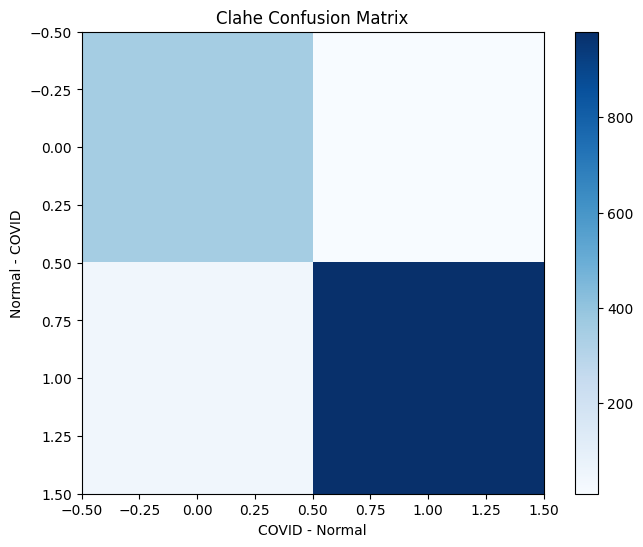

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_clahe, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Clahe Confusion Matrix")
plt.colorbar()
plt.xlabel("COVID - Normal")
plt.ylabel("Normal - COVID")
plt.show()

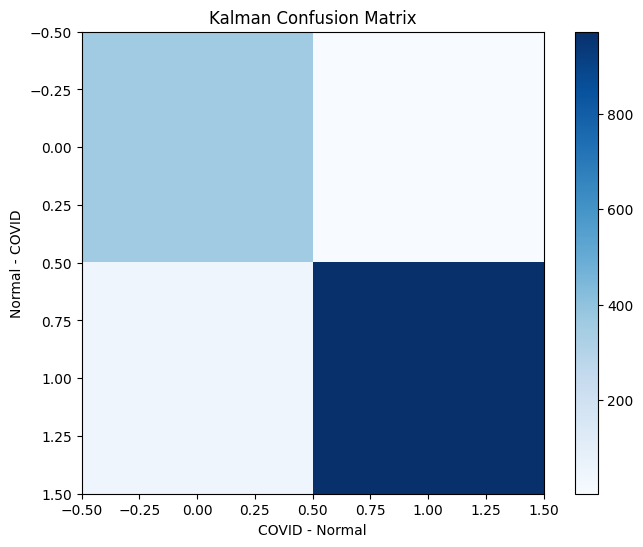

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_kalman, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Kalman Confusion Matrix")
plt.colorbar()
plt.xlabel("COVID - Normal")
plt.ylabel("Normal - COVID")
plt.show()


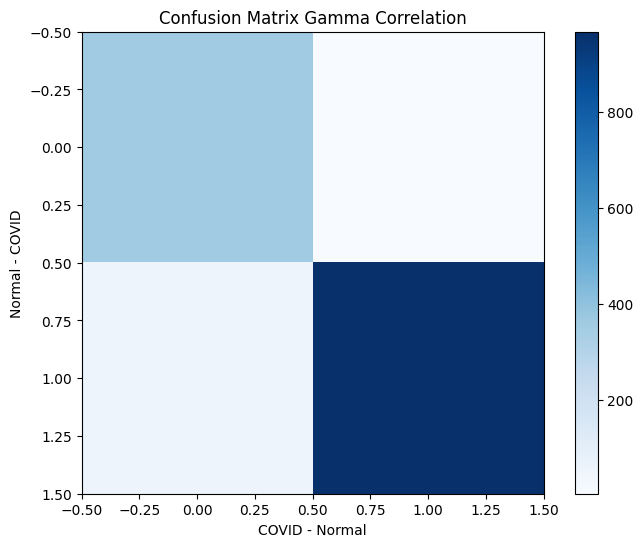

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_gamma, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Gamma Correlation")
plt.colorbar()
plt.xlabel("COVID - Normal")
plt.ylabel("Normal - COVID")
plt.show()
